## 📈 Predicting Premier League Final Positions Using Betting Odds, Probabilistic Modelling & Simulation

**Competition:** English Rugby Premiership 2025/26  
**Purpose:** Estimate probabilities of final league positions using betting market information and simulation  
**Methods:** Odds-implied probabilities, Monte Carlo simulation, scenario analysis  
**Author:** [Victoria Friss de Kereki](https://www.linkedin.com/in/victoria-friss-de-kereki/) 
**Medium Article:** [Predicting Premier League Final Positions Using Betting Odds, Probabilistic Modelling & Simulation](https://medium.com/p/2720ec335c3c)

---

**Notebook first written:** `17/01/2026`  
**Last updated:** `26/01/2026`  

> This notebook develops a probabilistic framework to predict final English Rugby Premiership final positions using betting odds as market-based expectations.
>
> Betting odds are transformed into implied probabilities and adjusted for bookmaker margin. These probabilities are then used to simulate the remainder of the season via Monte Carlo methods, generating distributions over final points totals and league positions.
>
> The analysis focuses on estimating the likelihood of key outcomes such as title wins, top-four finishes, relegation, and mid-table placements. Results are presented at team level with uncertainty intervals, and the framework can be extended to incorporate form, fixture difficulty, or alternative predictive inputs beyond betting markets.


<div style="text-align: left;">
    <img src="Images and others for Medium/Predicting PREMIERSHIP final positions.png"  
         alt="Predicting PREMIERSHIP final positions"  
         width="600">
</div>

In [1]:
# import soccerdata as sd

# Core
from datetime import datetime, timedelta
import os

# Data manipulation
import numpy as np
import pandas as pd

# APIs & environment
import requests
from dotenv import load_dotenv

# Statistics
from scipy.stats import poisson

# Visualisation
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

## 1. Premiership Final Standings (ESPN Scraping)
##### Adapting the ESPN scraper I built in my previous project to be used for Rugby Premiership instead of Football Premier League.

In [2]:
url = "https://www.espn.com/rugby/standings/_/league/267979"
tables = pd.read_html(url)

# Fix ESPN header issue
teams_raw = tables[0].copy()

# Move column names into first row
teams_raw.loc[-1] = teams_raw.columns
teams_raw.index = teams_raw.index + 1
teams_raw = teams_raw.sort_index().reset_index(drop=True)

# Stats table is fine as-is
stats = tables[1]

# Parse team table
teams = pd.DataFrame()

teams["position"] = (
    teams_raw.iloc[:, 0]
    .astype(str)
    .str.extract(r"^(\d+)")
    .astype(int)
)

teams["team"] = (
    teams_raw.iloc[:, 0]
    .astype(str)
    .str.replace(r"^\d+", "", regex=True)        # remove position
    .str.replace(r"^[A-Z]{2,3}", "", regex=True) # remove abbreviation
    .str.strip()
)

# Parse stats table
stats.columns = [
    "gp", "w", "d", "l", "bye",
    "pf", "pa", "tf", "ta",
    "tbp", "lbp", "bp",
    "pd", "pts"
]

stats = stats.apply(
    lambda c: (
        c.astype(str)
         .str.replace("+", "", regex=False)
         .astype(int)
    )
)

# Combine
premiership = pd.concat([teams, stats], axis=1)

premiership

,position,team,gp,w,d,l,bye,pf,pa,tf,ta,tbp,lbp,bp,pd,pts
0,1,Northampton Saints,10,8,1,1,0,390,282,58,39,9,0,9,108,43
1,2,Bath Rugby,10,8,0,2,0,343,237,50,34,8,1,9,106,41
2,3,Bristol Rugby,10,8,0,2,0,290,235,41,34,5,0,5,55,37
3,4,Leicester Tigers,10,7,0,3,0,301,238,41,31,7,1,8,63,36
4,5,Exeter Chiefs,10,6,1,3,0,272,179,37,24,6,3,9,93,35
5,6,Saracens,10,5,0,5,0,383,248,56,35,9,3,12,135,32
6,7,Sale Sharks,10,3,0,7,0,285,297,39,43,5,3,8,-12,20
7,8,Gloucester Rugby,10,1,0,9,0,214,335,32,45,4,3,7,-121,11
8,9,Harlequins,10,2,0,8,0,196,351,26,52,2,0,2,-155,10
9,10,Newcastle Falcons,10,1,0,9,0,167,439,23,66,1,0,1,-272,5


## 2. Get betting odds using API

#### No matches betting odds available as there is still over a month to go until the next match.

## 3. Get fixtures for upcoming EPL games
#### No API available for Premiership Rugby, so performing web scraping from https://www.skysports.com/rugby-union/competitions/gallagher-prem/fixtures instead.

In [6]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = "https://www.skysports.com/rugby-union/competitions/gallagher-prem/fixtures"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}

response = requests.get(url, headers=headers)
response.raise_for_status()

soup = BeautifulSoup(response.text, "html.parser")

fixtures_container = soup.find("div", class_="fixres__body")

month = None
date = None

dates = []
months = []
home_teams = []
away_teams = []
times = []

for elem in fixtures_container.children:
    # Skip empty elements or strings
    if not hasattr(elem, "name"):
        continue

    # Month header
    if elem.name == "h3" and "fixres__header1" in elem.get("class", []):
        month = elem.get_text(strip=True)

    # Date header
    elif elem.name == "h4" and "fixres__header2" in elem.get("class", []):
        date = elem.get_text(strip=True)

    # Match item
    elif elem.name == "div" and "fixres__item" in elem.get("class", []):
        home = elem.select_one("span.matches__participant--side1 span.swap-text__target").get_text(strip=True)
        away = elem.select_one("span.matches__participant--side2 span.swap-text__target").get_text(strip=True)
        time = elem.select_one("span.matches__date").get_text(strip=True)

        months.append(month)
        dates.append(date)
        home_teams.append(home)
        away_teams.append(away)
        times.append(time)

# Build DataFrame
df = pd.DataFrame({
    "month": months,
    "date": dates,
    "time": times,
    "home_team": home_teams,
    "away_team": away_teams
})

print(df.head())
print("Total fixtures scraped:", len(df))

        month                 date   time         home_team  \
0  March 2026    Friday 20th March  19:45              Bath   
1  March 2026  Saturday 21st March  15:00        Harlequins   
2  March 2026  Saturday 21st March  15:00       Northampton   
3  March 2026  Saturday 21st March  15:05            Exeter   
4  March 2026    Sunday 22nd March  15:00  Leicester Tigers   

             away_team  
0             Saracens  
1           Gloucester  
2  Newcastle Red Bulls  
3          Sale Sharks  
4        Bristol Bears  
Total fixtures scraped: 43


In [134]:
# Remove fixtures with TBC in either team
df_future = df[~df["home_team"].str.contains("TBC") & ~df["away_team"].str.contains("TBC")].reset_index(drop=True)

print("Total fixtures after removing TBC matches:", len(df_future))

Total fixtures after removing TBC matches: 40


In [135]:
df_future

,month,date,time,home_team,away_team
0,March 2026,Friday 20th March,19:45,Bath,Saracens
1,March 2026,Saturday 21st March,15:00,Harlequins,Gloucester
2,March 2026,Saturday 21st March,15:00,Northampton,Newcastle Red Bulls
3,March 2026,Saturday 21st March,15:05,Exeter,Sale Sharks
4,March 2026,Sunday 22nd March,15:00,Leicester Tigers,Bristol Bears
5,March 2026,Friday 27th March,19:45,Newcastle Red Bulls,Exeter
6,March 2026,Saturday 28th March,13:00,Gloucester,Leicester Tigers
7,March 2026,Saturday 28th March,15:30,Bristol Bears,Harlequins
8,March 2026,Saturday 28th March,18:00,Saracens,Northampton
9,March 2026,Sunday 29th March,15:00,Sale Sharks,Bath


## 4. Get this season (2025/26) and last season (2024/25) results
#### Again, no API available here. Will do web scraping from https://www.skysports.com/rugby-union/competitions/gallagher-prem/results/2025-26 and previous seasons.

In [9]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

def scrape_sky_sports_results(url, season_label):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
    }
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, "html.parser")
    
    container = soup.find("div", class_="fixres__body")
    if not container:
        print(f"No results container found at {url}")
        return pd.DataFrame()
    
    month = None
    date_text = None
    
    rows = []
    
    for elem in container.children:
        if not hasattr(elem, "name"):
            continue
        
        # Month header
        if elem.name == "h3" and "fixres__header1" in elem.get("class", []):
            month = elem.get_text(strip=True)
        
        # Date header
        elif elem.name == "h4" and "fixres__header2" in elem.get("class", []):
            date_text = elem.get_text(strip=True)
        
        # Match item
        elif elem.name == "div" and "fixres__item" in elem.get("class", []):
            home = elem.select_one("span.matches__participant--side1 span.swap-text__target")
            away = elem.select_one("span.matches__participant--side2 span.swap-text__target")
            
            # Scores appear in spans with class matches__teamscores-side
            scores = elem.select("span.matches__teamscores-side")
            if len(scores) >= 2:
                home_score = scores[0].get_text(strip=True)
                away_score = scores[1].get_text(strip=True)
            else:
                # If no score found, treat as n/a
                home_score = None
                away_score = None
            
            # Clean text
            home_team = home.get_text(strip=True) if home else None
            away_team = away.get_text(strip=True) if away else None
            
            # Combine date and month into full date string
            full_date_str = f"{date_text} {month}"
            # Attempt to parse
            try:
                match_date = datetime.strptime(full_date_str, "%A %dth %B %Y")
            except Exception:
                try:
                    match_date = datetime.strptime(full_date_str, "%A %dnd %B %Y")
                except Exception:
                    match_date = full_date_str
            
            rows.append({
                "season": season_label,
                "date": match_date,
                "home_team": home_team,
                "home_score": home_score,
                "away_team": away_team,
                "away_score": away_score
            })
    
    return pd.DataFrame(rows)


# URLs and season labels
urls = [
    ("https://www.skysports.com/rugby-union/competitions/gallagher-prem/results/2025-26", "2025-26"),
    ("https://www.skysports.com/rugby-union/competitions/gallagher-prem/results/2024-25", "2024-25"),
    ("https://www.skysports.com/rugby-union/competitions/gallagher-prem/results/2023-24", "2023-24"),
]

# Scrape all
all_results = pd.concat(
    scrape_sky_sports_results(url, season) for url, season in urls
).reset_index(drop=True)

print(all_results.head())
print("Total past results:", len(all_results))


    season                                date    home_team home_score  \
0  2025-26  Saturday 24th January January 2026       Exeter          3   
1  2025-26  Saturday 24th January January 2026     Saracens         73   
2  2025-26  Saturday 24th January January 2026   Harlequins          7   
3  2025-26  Saturday 24th January January 2026  Sale Sharks         29   
4  2025-26    Friday 23rd January January 2026   Gloucester         26   

             away_team away_score  
0        Bristol Bears          8  
1  Newcastle Red Bulls         14  
2     Leicester Tigers         34  
3          Northampton         43  
4                 Bath         30  
Total past results: 236


In [184]:
all_results.head()

,season,date,home_team,home_score,away_team,away_score
0,2025-26,2026-01-24,Exeter,3,Bristol Bears,8
1,2025-26,2026-01-24,Saracens,73,Newcastle Red Bulls,14
2,2025-26,2026-01-24,Harlequins,7,Leicester Tigers,34
3,2025-26,2026-01-24,Sale Sharks,29,Northampton,43
4,2025-26,2026-01-23,Gloucester,26,Bath,30


In [13]:
import pandas as pd
from datetime import datetime

def clean_match_dates(df):
    # Remove duplicate month if it exists in the day string
    df['date_clean'] = df['date'].str.replace(r'(\b\w+)\s(\1\s\d{4})', r'\2', regex=True)
    
    # Try parsing to datetime
    def parse_date(d):
        try:
            return datetime.strptime(d, "%A %dth %B %Y")
        except:
            try:
                return datetime.strptime(d, "%A %dnd %B %Y")
            except:
                try:
                    return datetime.strptime(d, "%A %dst %B %Y")
                except:
                    try:
                        return datetime.strptime(d, "%A %drd %B %Y")
                    except:
                        return d  # fallback: leave as string
    
    df['date'] = df['date_clean'].apply(parse_date)
    df.drop(columns=['date_clean'], inplace=True)
    return df

# Apply to your past results DataFrame
all_results_fixed = clean_match_dates(all_results)
all_results_fixed.head()

,season,date,home_team,home_score,away_team,away_score
0,2025-26,2026-01-24,Exeter,3,Bristol Bears,8
1,2025-26,2026-01-24,Saracens,73,Newcastle Red Bulls,14
2,2025-26,2026-01-24,Harlequins,7,Leicester Tigers,34
3,2025-26,2026-01-24,Sale Sharks,29,Northampton,43
4,2025-26,2026-01-23,Gloucester,26,Bath,30


In [23]:
# Sort by season and date just in case
all_results_fixed = all_results_fixed.sort_values(["season", "date"]).reset_index(drop=True)

# Seasons to remove playoffs from (previous 2 seasons)
previous_seasons = ['2024-25', '2023-24']

# Function to remove last N matches per season for specific seasons
def remove_playoffs_specific(df, seasons, playoff_count=3):
    result = []
    for season, group in df.groupby("season"):
        if season in seasons:
            result.append(group.iloc[:-playoff_count])
        else:
            result.append(group)
    return pd.concat(result).reset_index(drop=True)

# Apply
all_results_no_playoffs = remove_playoffs_specific(all_results_fixed, previous_seasons, playoff_count=3)

print("Total matches after removing playoffs from previous seasons:", len(all_results_no_playoffs))

Total matches after removing playoffs from previous seasons: 230


In [24]:
all_results_no_playoffs

,season,date,home_team,home_score,away_team,away_score
0,2023-24,2023-10-13,Bristol Bears,25,Leicester Tigers,14
1,2023-24,2023-10-14,Exeter,65,Saracens,10
2,2023-24,2023-10-14,Bath,34,Newcastle Red Bulls,26
3,2023-24,2023-10-14,Gloucester,29,Harlequins,28
4,2023-24,2023-10-15,Sale Sharks,20,Northampton,15
...,...,...,...,...,...,...
225,2025-26,2026-01-23,Gloucester,26,Bath,30
226,2025-26,2026-01-24,Exeter,3,Bristol Bears,8
227,2025-26,2026-01-24,Saracens,73,Newcastle Red Bulls,14
228,2025-26,2026-01-24,Harlequins,7,Leicester Tigers,34


In [111]:
# Sort by date just to be safe
all_results_no_playoffs = all_results_no_playoffs.sort_values(["season", "date"]).reset_index(drop=True)

# Identify last 5 matches of the current season
current_season = '2025-26'
mask = all_results_no_playoffs['season'] == current_season
current_season_df = all_results_no_playoffs[mask]

# Drop last 5 matches of this season
trimmed_current_season = current_season_df.iloc[:-5]

# Keep all other seasons unchanged
all_other_seasons = all_results_no_playoffs[all_results_no_playoffs['season'] != current_season]

# Combine back
past_premiership_balanced = pd.concat([all_other_seasons, trimmed_current_season]).sort_values(["season", "date"]).reset_index(drop=True)

# Quick check
print("Total matches after trimming last 5 of current season:", len(all_results_balanced))

Total matches after trimming last 5 of current season: 225


In [112]:
past_premiership_balanced.tail()

,season,date,home_team,home_score,away_team,away_score
220,2025-26,2026-01-02,Bristol Bears,19,Sale Sharks,17
221,2025-26,2026-01-02,Newcastle Red Bulls,25,Gloucester,19
222,2025-26,2026-01-03,Bath,33,Exeter,26
223,2025-26,2026-01-03,Northampton,66,Harlequins,21
224,2025-26,2026-01-04,Leicester Tigers,36,Saracens,28


### I need tries and other breakdowns. Will do scraping from a different source.

In [209]:
import re

def scrape_match_stats(url):
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to load {url}")
        return None
    
    soup = BeautifulSoup(response.text, "html.parser")
    
    # Extract season from URL
    match = re.search(r'/premiership/(\d{4}-\d{4})/', url)
    season = match.group(1) if match else None
    
    # Team names
    team_tags = soup.select('a[data-testid="atom-participant-banner"] div.overflow-hidden')
    if len(team_tags) != 2:
        print(f"Couldn't find team names for {url}")
        return None
    
    home_team = team_tags[0].text.strip()
    away_team = team_tags[1].text.strip()
    
    # Team scores
    score_tags = soup.select('div[data-testid="team-match-header-score-atom-container"] div[data-testid="match-score-atom-score-content-box-score"]')
    if len(score_tags) == 2:
        home_score = int(score_tags[0].text.strip())
        away_score = int(score_tags[1].text.strip())
    else:
        home_score = away_score = None
    
    # Match date
    date_tag = soup.select_one('div[data-testid="molecule-match-header-top"] div.caption-2.text-neutral-05')
    if date_tag:
        date_text = date_tag.text.strip()
        match_date = date_text.split("/")[-1].strip() if "/" in date_text else None
    else:
        match_date = None
    
    # Stats rows
    stats_rows = soup.select('div[data-testid="molecule-team-action-row"]')
    stats_dict = {}
    
    for row in stats_rows:
        stat_name_tag = row.find('span')
        if not stat_name_tag:
            continue
        stat_name = stat_name_tag.text.strip()
        
        participants = row.select('div[data-testid="molecule-team-action-row-participant"]')
        if len(participants) != 2:
            continue
        
        home_val = int(participants[0].find('div', class_='caps-s6-fx').text.strip())
        away_val = int(participants[1].find('div', class_='caps-s6-fx').text.strip())
        
        stats_dict[stat_name] = [home_val, away_val]
    
    return {
        "season": season,
        "date": match_date,
        "home_team": home_team,
        "away_team": away_team,
        "home_score": home_score,
        "away_score": away_score,
        **stats_dict
    }

##### Generate list of URLs

In [194]:
season_match_ranges = {
    "2023-2024": {"start": 1457678, "end": 1457767},  # 90
    "2024-2025": {"start": 1548080, "end": 1548169},  # 90
    "2025-2026": {"start": 1628800, "end": 1628844},  # current season except last 5 matches
}


urls = []
season_counters = {s: 0 for s in season_match_ranges}

for _, row in all_results.iterrows():
    season = row["season"]
    start_year, end_year = season.split("-")
    season_str = f"{start_year}-20{end_year}"

    if season_str not in season_match_ranges:
        continue

    start = season_match_ranges[season_str]["start"]
    end = season_match_ranges[season_str]["end"]

    match_number = start + season_counters[season_str]

    # stop once season is full
    if match_number > end:
        continue

    url = (
        f"https://www.tntsports.co.uk/rugby/premiership/"
        f"{season_str}/live-match_mtc{match_number}/live.shtml"
    )

    urls.append(url)
    season_counters[season_str] += 1

In [212]:
import time

all_matches_stats = []

total = len(urls)

for i, url in enumerate(urls, start=1):
    print(f"[{i}/{total}] Scraping: {url}")

    try:
        match = scrape_match_stats(url)

        if match:
            all_matches_stats.append(match)
            print(f"    ✅ Success: {match['home_team']} vs {match['away_team']}")
        else:
            print("    ⚠️  No data returned")

    except Exception as e:
        print(f"    ❌ Error scraping {url}: {e}")

    # polite delay to avoid hammering the site
    time.sleep(1)

print("\nFinished scraping.")
print(f"Total successful matches: {len(all_matches_stats)}")

[1/225] Scraping: https://www.tntsports.co.uk/rugby/premiership/2023-2024/live-match_mtc1457678/live.shtml
    ✅ Success: Bristol Bears vs Leicester Tigers
[2/225] Scraping: https://www.tntsports.co.uk/rugby/premiership/2023-2024/live-match_mtc1457679/live.shtml
    ✅ Success: Exeter Chiefs vs Saracens
[3/225] Scraping: https://www.tntsports.co.uk/rugby/premiership/2023-2024/live-match_mtc1457680/live.shtml
    ✅ Success: Bath Rugby vs Newcastle Red Bulls
[4/225] Scraping: https://www.tntsports.co.uk/rugby/premiership/2023-2024/live-match_mtc1457681/live.shtml
    ✅ Success: Gloucester Rugby vs Harlequins
[5/225] Scraping: https://www.tntsports.co.uk/rugby/premiership/2023-2024/live-match_mtc1457682/live.shtml
    ✅ Success: Sale Sharks vs Northampton Saints
[6/225] Scraping: https://www.tntsports.co.uk/rugby/premiership/2023-2024/live-match_mtc1457683/live.shtml
    ✅ Success: Newcastle Red Bulls vs Gloucester Rugby
[7/225] Scraping: https://www.tntsports.co.uk/rugby/premiership/2023-

In [213]:
# Convert list of dicts to DataFrame
df_matches = pd.DataFrame(all_matches_stats)
df_matches.head()

,season,date,home_team,away_team,home_score,away_score,Tries,Conversions,Penalties,Drops
0,2023-2024,13.10.2023,Bristol Bears,Leicester Tigers,25,14,"[3, 2]","[2, 2]","[2, 0]","[0, 0]"
1,2023-2024,14.10.2023,Exeter Chiefs,Saracens,65,10,"[11, 2]","[5, 0]","[0, 0]","[0, 0]"
2,2023-2024,14.10.2023,Bath Rugby,Newcastle Red Bulls,34,26,"[6, 3]","[2, 1]","[0, 3]","[0, 0]"
3,2023-2024,14.10.2023,Gloucester Rugby,Harlequins,29,28,"[4, 3]","[3, 2]","[1, 3]","[0, 0]"
4,2023-2024,15.10.2023,Sale Sharks,Northampton Saints,20,15,"[3, 2]","[1, 1]","[1, 1]","[0, 0]"


## Calculate bonus points in each match

In [145]:
import numpy as np

def assign_losing_bonus(row):
    # Home team
    if row['home_score'] < row['away_score'] and (row['away_score'] - row['home_score']) <= 7:
        home_lbp = 1
    else:
        home_lbp = 0
    # Away team
    if row['away_score'] < row['home_score'] and (row['home_score'] - row['away_score']) <= 7:
        away_lbp = 1
    else:
        away_lbp = 0
    return pd.Series([home_lbp, away_lbp])

past_premiership_balanced[['home_lbp', 'away_lbp']] = past_premiership_balanced.apply(assign_losing_bonus, axis=1)
past_premiership_balanced.tail()

,season,date,home_team,home_score,away_team,away_score,weight,home_lbp,away_lbp
220,2025-26,2026-01-02,Bristol Bears,19,Sale Sharks,17,1.982143,0,1
221,2025-26,2026-01-02,Newcastle Red Bulls,25,Gloucester,19,1.986607,0,1
222,2025-26,2026-01-03,Bath,33,Exeter,26,1.991071,0,1
223,2025-26,2026-01-03,Northampton,66,Harlequins,21,1.995536,0,0
224,2025-26,2026-01-04,Leicester Tigers,36,Saracens,28,2.000000,0,0


In [146]:
def match_points(row):
    # Home team
    if row['home_score'] > row['away_score']:
        home_pts = 4
        away_pts = 0
    elif row['home_score'] < row['away_score']:
        home_pts = 0
        away_pts = 4
    else:  # draw
        home_pts = 2
        away_pts = 2
    # Add losing bonus
    home_pts += row['home_lbp']
    away_pts += row['away_lbp']
    return pd.Series([home_pts, away_pts])

past_premiership_balanced[['home_pts', 'away_pts']] = past_premiership_balanced.apply(match_points, axis=1)
past_premiership_balanced.head()

,season,date,home_team,home_score,away_team,away_score,weight,home_lbp,away_lbp,home_pts,away_pts
0,2023-24,2023-10-13,Bristol Bears,25,Leicester Tigers,14,1.000000,0,0,4,0
1,2023-24,2023-10-14,Exeter,65,Saracens,10,1.004464,0,0,4,0
2,2023-24,2023-10-14,Bath,34,Newcastle Red Bulls,26,1.008929,0,0,4,0
3,2023-24,2023-10-14,Gloucester,29,Harlequins,28,1.013393,0,1,4,1
4,2023-24,2023-10-15,Sale Sharks,20,Northampton,15,1.017857,0,1,4,1


#### Scraping this season with tries included, to calculate how many points scored tend to translate to 1 try bonus point.

In [147]:
import time
import pandas as pd

def scrape_prem_matches(start_id, end_id, delay=0.8):
    data = []

    for match_id in range(start_id, end_id + 1):
        match = scrape_prem_match(match_id)

        if match is not None:
            data.append(match)
        else:
            print(f"Skipped match {match_id}")

        time.sleep(delay)

    df = pd.DataFrame(data)


    return df

In [148]:
prem_matches = scrape_prem_matches(
    start_id=288927,
    end_id=288973
)

In [149]:
# Exeter Chiefs 38 - 0 Harlequins is not getting scraped properly because of that empty tries space in the HTML, so fixing it manually is easier here.
prem_matches.loc[prem_matches["match_id"] == 288946, ["home_tries", "away_tries"]] = [5, 0]

# Same issue with 0 tries in Exeter Chiefs	Bristol Bears.
prem_matches.loc[prem_matches["match_id"] == 288972, ["home_tries", "away_tries"]] = [0, 0]

In [150]:
prem_matches.head()

,match_id,date,home_team,away_team,home_score,away_score,home_tries,away_tries
0,288927,"Thu, 25 Sept 2025",Sale Sharks,Gloucester Rugby,27,10,4.0,1.0
1,288928,"Fri, 26 Sept 2025",Harlequins,Bath Rugby,31,47,5.0,7.0
2,288929,"Fri, 26 Sept 2025",Newcastle Red Bulls,Saracens,17,39,2.0,5.0
3,288930,"Sun, 28 Sept 2025",Northampton Saints,Exeter Chiefs,33,33,5.0,5.0
4,288931,"Sun, 28 Sept 2025",Bristol Bears,Leicester Tigers,42,24,5.0,4.0


#### Analyse bonus points and create rule to assign them.

In [151]:
home = prem_matches.assign(
    team=prem_matches["home_team"],
    tries=prem_matches["home_tries"],
    points_for=prem_matches["home_score"],
)

away = prem_matches.assign(
    team=prem_matches["away_team"],
    tries=prem_matches["away_tries"],
    points_for=prem_matches["away_score"],
)

tbp_df = pd.concat([home, away], ignore_index=True)[
    ["match_id", "date", "team", "points_for", "tries"]
]

tbp_df["try_bonus"] = (tbp_df["tries"] >= 4).astype(int)

tbp_df.head()

,match_id,date,team,points_for,tries,try_bonus
0,288927,"Thu, 25 Sept 2025",Sale Sharks,27,4.0,1
1,288928,"Fri, 26 Sept 2025",Harlequins,31,5.0,1
2,288929,"Fri, 26 Sept 2025",Newcastle Red Bulls,17,2.0,0
3,288930,"Sun, 28 Sept 2025",Northampton Saints,33,5.0,1
4,288931,"Sun, 28 Sept 2025",Bristol Bears,42,5.0,1


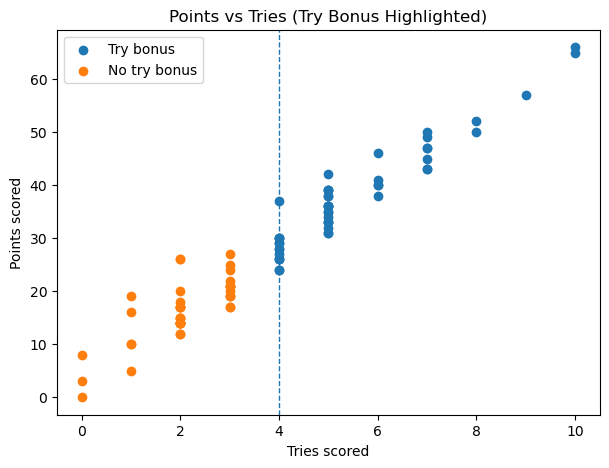

In [152]:
import matplotlib.pyplot as plt

# Split data by try bonus
tbp_yes = tbp_df[tbp_df["try_bonus"] == 1]
tbp_no = tbp_df[tbp_df["try_bonus"] == 0]

plt.figure(figsize=(7, 5))

# Scatter plots
plt.scatter(
    tbp_yes["tries"],
    tbp_yes["points_for"],
    label="Try bonus",
)
plt.scatter(
    tbp_no["tries"],
    tbp_no["points_for"],
    label="No try bonus",
)

# Labels and title
plt.xlabel("Tries scored")
plt.ylabel("Points scored")
plt.title("Points vs Tries (Try Bonus Highlighted)")
plt.legend()

# Optional: show the TBP threshold
plt.axvline(4, linestyle="--", linewidth=1)

plt.show()

In [153]:
# Ensure clean types
tbp_df["points_for"] = tbp_df["points_for"].astype(int)
tbp_df["try_bonus"] = tbp_df["try_bonus"].astype(int)

# For each points_for value, check if any team at that score did NOT get TBP
summary = (
    tbp_df
    .groupby("points_for")["try_bonus"]
    .agg(["count", "min", "mean"])
    .reset_index()
    .sort_values("points_for")
)

summary[12:22]

,points_for,count,min,mean
12,20,2,0,0.000000
13,21,4,0,0.000000
14,22,1,0,0.000000
15,24,3,0,0.666667
16,25,1,0,0.000000
17,26,5,0,0.600000
18,27,3,0,0.333333
19,28,2,1,1.000000
20,29,2,1,1.000000
21,30,3,1,1.000000


In [154]:
TRY_BONUS_PROB_24_27 = (
    tbp_df
    .loc[tbp_df["points_for"].between(24, 27)]
    ["try_bonus"]
    .mean()
)

TRY_BONUS_PROB_24_27

0.5

## 5. Calculate probabilities of W/D/L, and bonus points, for each match

In [155]:
# Add weights: more recent games = more weight
# df_all["date"] = pd.to_datetime(df_all["utcDate"])
past_premiership_balanced["weight"] = np.linspace(1, 2, len(past_premiership_balanced))  # simple linear weighting

In [156]:
past_premiership_balanced.tail()

,season,date,home_team,home_score,away_team,away_score,weight,home_lbp,away_lbp,home_pts,away_pts
220,2025-26,2026-01-02,Bristol Bears,19,Sale Sharks,17,1.982143,0,1,4,1
221,2025-26,2026-01-02,Newcastle Red Bulls,25,Gloucester,19,1.986607,0,1,4,1
222,2025-26,2026-01-03,Bath,33,Exeter,26,1.991071,0,1,4,1
223,2025-26,2026-01-03,Northampton,66,Harlequins,21,1.995536,0,0,4,0
224,2025-26,2026-01-04,Leicester Tigers,36,Saracens,28,2.000000,0,0,4,0


In [157]:
# Compute home advantage
# Home advantage = average home points - average away points

# Convert score columns to numeric (integers), forcing errors to NaN just in case
past_premiership_balanced['home_score'] = pd.to_numeric(past_premiership_balanced['home_score'], errors='coerce')
past_premiership_balanced['away_score'] = pd.to_numeric(past_premiership_balanced['away_score'], errors='coerce')

In [158]:
home_advantage = past_premiership_balanced['home_score'].mean() - past_premiership_balanced['away_score'].mean()
print("Home advantage (average points):", home_advantage)

Home advantage (average points): 7.475555555555555


In [160]:
# All teams
teams = pd.unique(
    past_premiership_balanced[["home_team", "away_team"]]
    .values.ravel("K")
)

attack = pd.Series(1.0, index=teams)
defense = pd.Series(1.0, index=teams)

team_stats = {}

for team in teams:
    home_games = past_premiership_balanced[
        past_premiership_balanced["home_team"] == team
    ]
    away_games = past_premiership_balanced[
        past_premiership_balanced["away_team"] == team
    ]

    points_scored = (
        (home_games["home_score"] * home_games["weight"]).sum()
        + (away_games["away_score"] * away_games["weight"]).sum()
    )

    points_conceded = (
        (home_games["away_score"] * home_games["weight"]).sum()
        + (away_games["home_score"] * away_games["weight"]).sum()
    )

    matches = home_games["weight"].sum() + away_games["weight"].sum()

    team_stats[team] = {
        "scored": points_scored / matches,
        "conceded": points_conceded / matches
    }

# League average points per team per match
league_avg_points = (
    past_premiership_balanced["home_score"].mean()
    + past_premiership_balanced["away_score"].mean()
) / 2

# Strengths relative to league
for team in teams:
    attack[team] = team_stats[team]["scored"] / league_avg_points
    defense[team] = team_stats[team]["conceded"] / league_avg_points

In [161]:
strengths_df = pd.DataFrame({
    "team": attack.index,
    "attack_strength": attack.values,
    "defence_strength": defense.values
}).sort_values("attack_strength", ascending=False)

strengths_df

,team,attack_strength,defence_strength
0,Bristol Bears,1.233252,1.035553
2,Bath,1.219532,0.849302
6,Northampton,1.151231,1.005026
7,Saracens,1.112287,0.908326
8,Leicester Tigers,1.024899,0.884747
4,Sale Sharks,0.996303,0.905382
1,Exeter,0.958447,0.926035
3,Gloucester,0.958326,1.124618
9,Harlequins,0.891234,1.096340
5,Newcastle Red Bulls,0.579432,1.391377


In [163]:
def expected_points(home, away):
    mu_home = np.exp(
        np.log(league_avg_points)
        + np.log(attack[home])
        + np.log(defense[away])
        + home_advantage / league_avg_points
    )

    mu_away = np.exp(
        np.log(league_avg_points)
        + np.log(attack[away])
        + np.log(defense[home])
    )

    return mu_home, mu_away

In [164]:
def match_probabilities_points(
    home,
    away,
    max_points=75,  # this season 73 was the max scored in a match
    try_bonus_threshold=28,
    losing_bonus_margin=7
):
    mu_home, mu_away = expected_points(home, away)

    p_home = poisson.pmf(range(max_points + 1), mu_home)
    p_away = poisson.pmf(range(max_points + 1), mu_away)

    p_win_bonus = 0
    p_win_no_bonus = 0
    p_draw_bonus = 0
    p_draw_no_bonus = 0
    p_lose_2_bonus = 0
    p_lose_bonus_try = 0
    p_lose_bonus_lose = 0
    p_lose_no_bonus = 0

    for h in range(max_points + 1):
        for a in range(max_points + 1):
            prob = p_home[h] * p_away[a]

            home_tb = h >= try_bonus_threshold
            losing_bonus = abs(h - a) <= losing_bonus_margin

            if h > a:  # WIN
                if home_tb:
                    p_win_bonus += prob
                else:
                    p_win_no_bonus += prob

            elif h == a:  # DRAW
                if home_tb:
                    p_draw_bonus += prob
                else:
                    p_draw_no_bonus += prob

            else:  # LOSS
                if home_tb and losing_bonus:
                    p_lose_2_bonus += prob
                elif home_tb:
                    p_lose_bonus_try += prob
                elif losing_bonus:
                    p_lose_bonus_lose += prob
                else:
                    p_lose_no_bonus += prob

    return {
        "p_win_bonus": p_win_bonus,
        "p_win_no_bonus": p_win_no_bonus,
        "p_draw_bonus": p_draw_bonus,
        "p_draw_no_bonus": p_draw_no_bonus,
        "p_lose_2_bonus": p_lose_2_bonus,
        "p_lose_bonus_try": p_lose_bonus_try,
        "p_lose_bonus_lose": p_lose_bonus_lose,
        "p_lose_no_bonus": p_lose_no_bonus,
    }


In [165]:
results = []

for _, row in df_future.iterrows():
    home = row["home_team"]
    away = row["away_team"]

    probs = match_probabilities_points(home, away)

    results.append({
        "date": row["date"],
        "home_team": home,
        "away_team": away,
        **probs
    })

df_odds = pd.DataFrame(results)


In [166]:
df_odds

,date,home_team,away_team,p_win_bonus,p_win_no_bonus,p_draw_bonus,p_draw_no_bonus,p_lose_2_bonus,p_lose_bonus_try,p_lose_bonus_lose,p_lose_no_bonus
0,Friday 20th March,Bath,Saracens,0.943665,9.169445e-03,9.544281e-03,1.523237e-03,2.452925e-02,1.765565e-03,7.805585e-03,1.997480e-03
1,Saturday 21st March,Harlequins,Gloucester,0.783609,1.730888e-02,2.863976e-02,4.364942e-03,1.004301e-01,1.479613e-02,3.304879e-02,1.780225e-02
2,Saturday 21st March,Northampton,Newcastle Red Bulls,0.988382,5.425802e-06,9.087844e-08,3.188037e-08,8.378504e-08,2.627350e-10,4.475340e-08,5.069758e-10
3,Saturday 21st March,Exeter,Sale Sharks,0.658649,1.077878e-01,2.045350e-02,1.847916e-02,5.755760e-02,4.584365e-03,1.009334e-01,3.155497e-02
4,Sunday 22nd March,Leicester Tigers,Bristol Bears,0.821422,7.070065e-03,2.724767e-02,1.982812e-03,9.829846e-02,1.632610e-02,1.677791e-02,1.087454e-02
5,Friday 27th March,Newcastle Red Bulls,Exeter,0.004290,3.912481e-03,1.311451e-03,2.314085e-03,1.433987e-02,1.680831e-02,6.966288e-02,8.873611e-01
6,Saturday 28th March,Gloucester,Leicester Tigers,0.392471,2.935579e-02,3.999806e-02,1.030731e-02,2.035493e-01,6.265658e-02,1.183788e-01,1.432829e-01
7,Saturday 28th March,Bristol Bears,Harlequins,0.996028,2.778885e-04,1.036566e-03,3.932245e-05,2.141136e-03,9.829495e-05,1.758818e-04,3.336601e-05
8,Saturday 28th March,Saracens,Northampton,0.905229,4.760765e-03,1.702853e-02,1.146056e-03,5.330407e-02,6.490083e-03,8.182397e-03,3.859207e-03
9,Sunday 29th March,Sale Sharks,Bath,0.442747,4.249025e-02,3.808915e-02,1.322426e-02,1.728160e-01,4.117791e-02,1.301469e-01,1.193083e-01


## 6. Compare calculated probabilities to bookmaker ones

#### No betting probabilities, so this is not done.

## 7. Replace my estimates probabilities with the ones I have from odds, creating my final match probabilities

In [35]:
df_odds.head(2)

,utcDate,homeTeam,awayTeam,p_home_win,p_draw,p_away_win,home_norm,away_norm
0,2026-01-26T20:00:00Z,Everton FC,Leeds United FC,0.483798,0.25215,0.262731,everton,leeds united
1,2026-01-31T15:00:00Z,Brighton & Hove Albion FC,Everton FC,0.460659,0.25482,0.283332,brighton and hove albion,everton


In [36]:
betting_odds_avg.head(2)

,home_team,away_team,p_home_book,p_draw_book,p_away_book,home_norm,away_norm
0,Arsenal,Sunderland,0.759878,0.166518,0.073604,arsenal,sunderland
1,Brighton and Hove Albion,Everton,0.517599,0.258048,0.224353,brighton and hove albion,everton


In [37]:
df_final_probabilities = df_odds.merge(
    betting_odds_avg,
    left_on=["home_norm", "away_norm"],
    right_on=["home_norm", "away_norm"],
    how="left"
)

In [38]:
df_final_probabilities = df_final_probabilities[[
    "utcDate",
    "homeTeam",
    "awayTeam",
    "p_home_win",
    "p_draw",
    "p_away_win",
    "p_home_book",
    "p_draw_book",
    "p_away_book",
]]

df_final_probabilities

,utcDate,homeTeam,awayTeam,p_home_win,p_draw,p_away_win,p_home_book,p_draw_book,p_away_book
0,2026-01-26T20:00:00Z,Everton FC,Leeds United FC,0.483798,0.252150,0.262731,0.371258,0.301594,0.327148
1,2026-01-31T15:00:00Z,Brighton & Hove Albion FC,Everton FC,0.460659,0.254820,0.283332,0.517599,0.258048,0.224353
2,2026-01-31T15:00:00Z,Leeds United FC,Arsenal FC,0.164150,0.200730,0.629051,0.153816,0.231198,0.614986
3,2026-01-31T15:00:00Z,Wolverhampton Wanderers FC,AFC Bournemouth,0.264887,0.218474,0.511896,0.301451,0.264680,0.433869
4,2026-01-31T17:30:00Z,Chelsea FC,West Ham United FC,0.696273,0.168438,0.122443,0.630500,0.210900,0.158600
...,...,...,...,...,...,...,...,...,...
146,2026-05-24T15:00:00Z,Liverpool FC,Brentford FC,0.564042,0.197011,0.228989,NaN,NaN,NaN
147,2026-05-24T15:00:00Z,Manchester City FC,Aston Villa FC,0.575068,0.215298,0.205142,NaN,NaN,NaN
148,2026-05-24T15:00:00Z,Nottingham Forest FC,AFC Bournemouth,0.417804,0.236658,0.343129,NaN,NaN,NaN
149,2026-05-24T15:00:00Z,Tottenham Hotspur FC,Everton FC,0.419584,0.257934,0.321449,NaN,NaN,NaN


In [39]:
df_final_probabilities["p_home_final"] = np.where(
    df_final_probabilities["p_home_book"].notna(),
    df_final_probabilities["p_home_book"],
    df_final_probabilities["p_home_win"]
)

df_final_probabilities["p_draw_final"] = np.where(
    df_final_probabilities["p_draw_book"].notna(),
    df_final_probabilities["p_draw_book"],
    df_final_probabilities["p_draw"]
)

df_final_probabilities["p_away_final"] = np.where(
    df_final_probabilities["p_away_book"].notna(),
    df_final_probabilities["p_away_book"],
    df_final_probabilities["p_away_win"]
)

In [40]:
print("Used betting odds:", df_final_probabilities["p_home_book"].notna().sum())
print("Used model:", df_final_probabilities["p_home_book"].isna().sum())


Used betting odds: 21
Used model: 130


In [41]:
df_final_probabilities = df_final_probabilities[[
    "utcDate",
    "homeTeam",
    "awayTeam",
    "p_home_final",
    "p_draw_final",
    "p_away_final"
]]

In [42]:
df_final_probabilities

,utcDate,homeTeam,awayTeam,p_home_final,p_draw_final,p_away_final
0,2026-01-26T20:00:00Z,Everton FC,Leeds United FC,0.371258,0.301594,0.327148
1,2026-01-31T15:00:00Z,Brighton & Hove Albion FC,Everton FC,0.517599,0.258048,0.224353
2,2026-01-31T15:00:00Z,Leeds United FC,Arsenal FC,0.153816,0.231198,0.614986
3,2026-01-31T15:00:00Z,Wolverhampton Wanderers FC,AFC Bournemouth,0.301451,0.264680,0.433869
4,2026-01-31T17:30:00Z,Chelsea FC,West Ham United FC,0.630500,0.210900,0.158600
...,...,...,...,...,...,...
146,2026-05-24T15:00:00Z,Liverpool FC,Brentford FC,0.564042,0.197011,0.228989
147,2026-05-24T15:00:00Z,Manchester City FC,Aston Villa FC,0.575068,0.215298,0.205142
148,2026-05-24T15:00:00Z,Nottingham Forest FC,AFC Bournemouth,0.417804,0.236658,0.343129
149,2026-05-24T15:00:00Z,Tottenham Hotspur FC,Everton FC,0.419584,0.257934,0.321449


In [43]:
df_final_probabilities["homeTeam"].unique()

array(['Everton FC', 'Brighton & Hove Albion FC', 'Leeds United FC',
       'Wolverhampton Wanderers FC', 'Chelsea FC', 'Liverpool FC',
       'Aston Villa FC', 'Manchester United FC', 'Nottingham Forest FC',
       'Tottenham Hotspur FC', 'Sunderland AFC', 'AFC Bournemouth',
       'Arsenal FC', 'Burnley FC', 'Fulham FC', 'Newcastle United FC',
       'West Ham United FC', 'Crystal Palace FC', 'Manchester City FC',
       'Brentford FC'], dtype=object)

In [44]:
name_map = {
    "Aston Villa FC": "Aston Villa",
    "Brighton & Hove Albion FC": "Brighton & Hove Albion",
    "AFC Bournemouth": "AFC Bournemouth",   # keep as is
    "Bournemouth": "AFC Bournemouth",
    "Sunderland AFC": "Sunderland",
    "Newcastle United FC": "Newcastle United",
    "Manchester City FC": "Manchester City",
    "Manchester United FC": "Manchester United",
    "West Ham United FC": "West Ham United",
    "Wolverhampton Wanderers FC": "Wolverhampton Wanderers",
    "Tottenham Hotspur FC": "Tottenham Hotspur",
    "Crystal Palace FC": "Crystal Palace",
    "Brentford FC": "Brentford",
    "Everton FC": "Everton",
    "Leeds United FC": "Leeds United",
    "Chelsea FC": "Chelsea",
    "Liverpool FC": "Liverpool",
    "Nottingham Forest FC": "Nottingham Forest",
    "Burnley FC": "Burnley",
    "Fulham FC": "Fulham",
    "Arsenal FC": "Arsenal"
}

df_final_probabilities["home_team_norm"] = df_final_probabilities["homeTeam"].replace(name_map)
df_final_probabilities["away_team_norm"] = df_final_probabilities["awayTeam"].replace(name_map)

premierleague["team_norm"] = premierleague["team"].replace({
    "Brighton & Hove Albion": "Brighton & Hove Albion",
    "AFC Bournemouth": "AFC Bournemouth"
})


[01/26/26 10:11:46] WARNING  C:\Users\vicky\AppData\Local\Temp\ipykernel_11340\2477332962.py:25:    ]8;id=460485;file://C:\ProgramData\anaconda3\Lib\warnings.py\warnings.py]8;;\:]8;id=350144;file://C:\ProgramData\anaconda3\Lib\warnings.py#112\112]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_final_probabilities["home_team_norm"] =                                          
                             df_final_probabilities["homeTeam"].replace(name_map)                                  
                                                                                                                   

                    WARNING  C:\Users\vicky\AppData\Local\Temp\ipykernel_11340\2477332962.py:26:    ]8;id=869731;file://C:\ProgramData\anaconda3\Lib\warnings.py\warnings.py]8;;\:]8;id=210437;file://C:\ProgramData\anaconda3\Lib\warnings.py#112\112]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc = value instead                                                        
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               df_final_probabilities["away_team_norm"] =                                          
                             df_final_probabilities["awayTeam"].replace(name_map)                                  
                                                                                                                   

In [45]:
df_simulation = df_final_probabilities.copy()

In [46]:
# Normalize probabilities so they sum to 1
prob_cols = ["p_home_final", "p_draw_final", "p_away_final"]
df_simulation[prob_cols] = df_simulation[prob_cols].div(df_simulation[prob_cols].sum(axis=1), axis=0)

In [47]:
df_simulation.head()

,utcDate,homeTeam,awayTeam,p_home_final,p_draw_final,p_away_final,home_team_norm,away_team_norm
0,2026-01-26T20:00:00Z,Everton FC,Leeds United FC,0.371258,0.301594,0.327148,Everton,Leeds United
1,2026-01-31T15:00:00Z,Brighton & Hove Albion FC,Everton FC,0.517599,0.258048,0.224353,Brighton & Hove Albion,Everton
2,2026-01-31T15:00:00Z,Leeds United FC,Arsenal FC,0.153816,0.231198,0.614986,Leeds United,Arsenal
3,2026-01-31T15:00:00Z,Wolverhampton Wanderers FC,AFC Bournemouth,0.301451,0.264680,0.433869,Wolverhampton Wanderers,AFC Bournemouth
4,2026-01-31T17:30:00Z,Chelsea FC,West Ham United FC,0.630500,0.210900,0.158600,Chelsea,West Ham United


## 8. Run simulations to build the Premier League table probabilities

In [48]:
def simulate_once(fixtures, table):
    table_sim = table.copy()

    # Use normalized team name column
    points = dict(zip(table_sim["team_norm"], table_sim["pts"]))

    for _, row in fixtures.iterrows():
        home = row["home_team_norm"]
        away = row["away_team_norm"]

        # choose outcome
        probs = [row["p_home_final"], row["p_draw_final"], row["p_away_final"]]
        outcome = np.random.choice(["H", "D", "A"], p=probs)

        if outcome == "H":
            points[home] += 3
        elif outcome == "D":
            points[home] += 1
            points[away] += 1
        else:
            points[away] += 3

    result_df = table_sim.copy()
    result_df["pts"] = result_df["team_norm"].map(points)

    # sort by points and goal difference
    result_df = result_df.sort_values(["pts", "gd"], ascending=[False, False])
    result_df["position"] = np.arange(1, len(result_df)+1)

    return result_df


def run_simulations(fixtures, table, n_sim=10000):
    position_counts = {team: np.zeros(len(table)) for team in table["team_norm"]}

    for _ in range(n_sim):
        final_table = simulate_once(fixtures, table)

        for _, row in final_table.iterrows():
            position_counts[row["team_norm"]][row["position"]-1] += 1

    pos_df = pd.DataFrame(position_counts, index=np.arange(1, len(table)+1))
    pos_df.index.name = "position"
    return pos_df

In [49]:
# RUN
position_distribution = run_simulations(df_simulation, premierleague, n_sim=20000)

In [50]:
position_distribution.index.name = "TEAM"
position_distribution_t = position_distribution.T

In [51]:
position_distribution_pct = position_distribution_t.div(
    position_distribution_t.sum(axis=1),
    axis=0
) * 100


## 9. Preview and present the results graphically

In [52]:
# Build label mapping: "position  team" (extra space for 1-9)
team_labels = (
    premierleague[["team", "position"]]
    .set_index("team")["position"]
    .map(lambda pos: f"{pos}{'  ' if pos < 10 else ' '}")
)

# Join position and team name into one label
team_labels = (
    premierleague[["team", "position"]]
    .assign(
        label=lambda df: df.apply(
            lambda r: f"{r['position']}{'&nbsp;&nbsp;&nbsp;&nbsp;' if r['position'] < 10 else '&nbsp;&nbsp;'}{r['team']}",
            axis=1
        )
    )
    .set_index("team")["label"]
)


# Apply labels to your table index
position_distribution_pct.index = position_distribution_pct.index.map(team_labels)

# Drop position column if present
position_distribution_pct = position_distribution_pct.drop(columns=["position"], errors="ignore")

# Remove index name
position_distribution_pct.index.name = None


In [73]:
greens = plt.cm.Greens
green_cmap = LinearSegmentedColormap.from_list(
    "Greens_soft",
    greens(np.linspace(0.03, 0.65, 256))
)

vmax = 25

def zero_style(val):
    if val < 0.005:
        return "background-color: white !important;"
    return ""

# ---- transform ONLY for colouring ----
color_data = position_distribution_pct.copy()
color_data = (color_data / vmax).pow(0.65) * vmax

position_distribution_pct.style \
    .background_gradient(
        cmap=green_cmap,
        vmin=0,
        vmax=vmax,
        gmap=color_data,
        axis=None          # 🔑 THIS FIXES THE ERROR
    ) \
    .applymap(zero_style) \
    .format("{:.2f}%") \
    .set_table_styles([
        {"selector": "th", "props": [
            ("background-color", "#e6edf4"),
            ("color", "#333"),
            ("text-align", "center"),
            ("font-family", "Inter, Roboto, Arial, sans-serif"),
            ("font-size", "13px"),
            ("font-weight", "600")
        ]},

        {"selector": "th.col_heading", "props": [
            ("text-align", "center")
        ]},

        {"selector": "th.row_heading", "props": [
            ("text-align", "left"),
            ("font-size", "13px"),
            ("font-weight", "600"),
            ("white-space", "nowrap"),
            ("max-width", "250px"),
            ("overflow", "hidden"),
            ("text-overflow", "ellipsis")
        ]},

        {"selector": "tr:nth-child(odd) th.row_heading", "props": [
            ("background-color", "#fbfcfe")
        ]},
        {"selector": "tr:nth-child(even) th.row_heading", "props": [
            ("background-color", "#e6edf4")
        ]},

        {"selector": "td", "props": [
            ("text-align", "center"),
            ("font-family", "Inter, Roboto, Arial, sans-serif"),
            ("font-size", "12px"),
            ("font-weight", "500"),
            ("color", "#000")
        ]}
    ])


[01/26/26 10:42:01] WARNING  C:\Users\vicky\AppData\Local\Temp\ipykernel_11340\2330607219.py:26:    ]8;id=670326;file://C:\ProgramData\anaconda3\Lib\warnings.py\warnings.py]8;;\:]8;id=50376;file://C:\ProgramData\anaconda3\Lib\warnings.py#112\112]8;;\
                             FutureWarning: Styler.applymap has been deprecated. Use Styler.map                    
                             instead.                                                                              
                               .applymap(zero_style) \                                                             
                                                                                                                   

TEAM,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1 Arsenal,76.89%,19.52%,3.33%,0.24%,0.01%,0.01%,0.00%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
2 Manchester City,19.32%,54.03%,20.86%,4.40%,1.09%,0.22%,0.07%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
3 Aston Villa,3.62%,21.94%,49.98%,15.78%,5.89%,1.80%,0.66%,0.21%,0.06%,0.03%,0.01%,0.01%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
4 Manchester United,0.01%,0.33%,2.58%,11.76%,17.59%,20.68%,15.05%,10.79%,7.53%,5.19%,3.60%,2.30%,1.28%,0.83%,0.36%,0.11%,0.01%,0.00%,0.00%,0.00%
5 Chelsea,0.10%,2.04%,11.40%,29.41%,24.80%,14.51%,8.21%,4.33%,2.27%,1.33%,0.85%,0.36%,0.23%,0.12%,0.03%,0.01%,0.00%,0.00%,0.00%,0.00%
6 Liverpool,0.06%,1.99%,10.37%,28.41%,24.43%,15.79%,8.25%,4.56%,2.94%,1.57%,0.76%,0.42%,0.27%,0.11%,0.06%,0.01%,0.01%,0.00%,0.00%,0.00%
7 Fulham,0.00%,0.03%,0.21%,1.24%,3.69%,7.35%,10.40%,12.14%,12.55%,12.64%,10.97%,9.52%,7.41%,5.63%,3.64%,1.83%,0.69%,0.05%,0.00%,0.00%
8 Brentford,0.00%,0.05%,0.33%,2.48%,6.21%,10.50%,14.25%,14.13%,12.77%,10.88%,9.28%,7.08%,5.32%,3.28%,2.13%,1.01%,0.27%,0.03%,0.00%,0.00%
9 Newcastle United,0.00%,0.04%,0.61%,3.45%,8.08%,12.37%,15.35%,14.61%,12.21%,10.02%,7.71%,5.92%,4.34%,2.81%,1.47%,0.69%,0.30%,0.03%,0.00%,0.00%
10 Sunderland,0.00%,0.01%,0.07%,0.63%,1.62%,3.46%,5.66%,8.18%,9.71%,11.21%,12.55%,12.31%,11.28%,9.74%,7.24%,4.29%,1.98%,0.08%,0.01%,0.00%
